In [2]:
%precision 3
import numpy as np
import pandas as pd
from pathlib import Path
from IPython import display
from matplotlib import pyplot as plt, ticker, lines, patches
plt.style.use("minimal")

In [81]:
METADATA_ROWS_N     = 9                     # number of lines to skip in logfile
SPATIAL_SCALE       = 1000                  # spatial measurements were recorded in millimeters
SAMPLE_RATE         = 300                   # Hz (samples/second)
DISPATCH_MARGIN     = 0.4                   # number of seconds before dispatch to consider in analysis
CUP_RADIUS          = 4.6                   # radius of cup in cm
BALL_RADIUS         = 0.95                  # radius of ball marker
CENTROID_OFFSET     = 2.5                   # offset from plane of cup centroid to cup brim plane
DATA_PATH           = Path("../Data")       # path to measurement directories
SHOWCASE_PATH       = Path("../Showcase")   # path to showcase export directory
IGNORED_MARKERS     = ["Table", "TableEdge", "CupFront", "CupLeft", "CupRight", "CupFront_static", "CupLeft_static", "CupRight_static"]

In [4]:
# display.Image(SHOWCASE_PATH.joinpath("full.gif"))

In [461]:
class Recording:
    def __init__(self, datafile_path):
        self.events = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = None, 
            names = ("Type", "EventType", "Frame", "Time"), 
            skiprows = METADATA_ROWS_N, 
            on_bad_lines = "skip"
        )

        marker_names = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = None, 
            skiprows = METADATA_ROWS_N + len(self.events), 
            nrows = 1
        ).loc[0, 1:].values

        self.available_markers = list(sorted(marker_names))

        dataset = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = METADATA_ROWS_N + len(self.events) + 2, 
            usecols = lambda name: "Unnamed" not in name
        ).drop(columns = [f"{marker} {axis}" for axis in ["X", "Y", "Z"] for marker in IGNORED_MARKERS], errors = "ignore")

        dataset = dataset.set_index("Time")
        dataset.columns = dataset.columns.str.split(" ", expand = True)
        dataset = dataset.stack(0, dropna = False)
        dataset.index = dataset.index.rename(["Time", "Marker"])
        dataset = dataset.reset_index()

        dataset["TrialTag"] = dataset["Time"].isin(self.events[self.events["EventType"] == "Trial"]["Time"])
        dataset["Trial"] = (dataset["TrialTag"].astype(int).diff() > 0).cumsum()
        dataset = dataset[dataset["Trial"] > 0]

        trials = []
        for trial, segment in dataset.groupby("Trial"):
            segment["Time"] -= segment["Time"].min()
            trials.append(Trial(segment))

        self.data = pd.Series(data = trials, index = np.arange(1, len(trials) + 1), name = "Trial")

    def __repr__(self):
        return f"[Recording {self.id}] {len(self.data)} trials"

class Trial(pd.Series):
    def __init__(self, data, *args, **kwargs):
        pd.Series.__init__(self, {marker: self.process_marker_data(data) for marker, data in tuple(data.groupby("Marker", as_index = False))}, *args, **kwargs)
        self.enhance()
        self.determine_outcome()

    def process_marker_data(self, marker_data):
        data = marker_data[["Time", "X", "Y", "Z"]]
        data = data.set_index("Time")
        data = data.interpolate(limit_direction = "both")
        data = (data / SPATIAL_SCALE) * 100 # rescale from mm/s to cm
        return data.reset_index()

    def calculate_speed(self, subset):
        delta_pos = (subset[["X", "Y", "Z"]].shift(1).values - subset[["X", "Y", "Z"]].values) * SAMPLE_RATE
        speed = np.sqrt(np.sum(delta_pos ** 2, axis = 1))
        speed = pd.Series(speed).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average
        speed /= 100 # rescale from cm/s to m/s
        return speed

    def calculate_acceleration(self, subset):
        return (subset["Speed"].diff() / SAMPLE_RATE).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average

    def sync_and_trim(self, subset, reference_timepoint, pre = None, post = None):
        if pre and post:
            subset = subset[(subset["Time"] > reference_timepoint - pre) & (subset["Time"] < reference_timepoint + post)].copy()
        subset["Time"] -= subset["Time"].min()
        subset.index -= subset.index.min()
        return subset

    def recenter_to_cup(self, subset, cup_centroid):
        subset[["X", "Y", "Z"]] = subset[["X", "Y", "Z"]].subtract(cup_centroid)
        return subset

    def enhance(self):
        self.cup_centroid = self["CupCentroid"].iloc[0][["X", "Y", "Z"]]
        # adding derived measures
        for marker in self.index:
            self.recenter_to_cup(self[marker], self.cup_centroid)
            self[marker]["Speed"] = self.calculate_speed(self[marker])
            self[marker]["Acceleration"] = self.calculate_acceleration(self[marker])

        # trimming to throw by using max ball speed (terminal velocity)
        reference_timepoint = self["Ball"]["Time"][self["Ball"]["Speed"].replace(np.nan, 0).idxmax()]
        for marker in self.index:
            self[marker] = self.sync_and_trim(
                self[marker], 
                reference_timepoint, 
                pre = 1, 
                post = DISPATCH_MARGIN
            )

        # trimming and "centering" around throw movement instead of terminal velocity
        reference_timepoint = self["Ball"]["Time"][self["Ball"]["Acceleration"].replace(np.nan, 0).idxmax()]
        for marker in self.index:
            self[marker] = self.sync_and_trim(
                self[marker], 
                reference_timepoint, 
                pre = DISPATCH_MARGIN, 
                post = 0.6
            )
    
    def ball_distance_to_cup_centroid(self):
        return pd.DataFrame(dict(
            Time = self["Ball"]["Time"], 
            Distance = np.sqrt(np.sum((self["Ball"][["X", "Y"]].values - self["CupCentroid"][["X", "Y"]].values)**2, axis = 1))
        ))
    
    def determine_outcome(self):
        self.outcome = ((self["Ball"]["Z"] <= 0) & (self["Ball"]["Z"] >= -1.5) & (self.ball_distance_to_cup_centroid()["Distance"] <= (CUP_RADIUS - BALL_RADIUS))).any()

    def __repr__(self):
        return f"[Trial] {'Hit' if self.outcome else 'Miss'}"

class Session:
    def __init__(self, session_id):
        self.session_id = session_id

        recordings = []
        for recording_path in Path(DATA_PATH).joinpath(f"Session{self.session_id}").iterdir():
            if recording_path.suffix == ".tsv":
                recordings.append(dict(
                    Player = int(recording_path.name[6]),
                    Condition = recording_path.stem.split("_")[1],
                    Recording = Recording(datafile_path=recording_path).data
                ))
        self.data = pd.DataFrame(recordings)

    def __repr__(self):
        return f"[Session {self.session_id}]" + "\n" + self.data[["Player", "Condition"]].to_string(index = False)

session = Session(session_id = 5)
print(session)

data = session.data

[Session 5]
 Player Condition
      1  Darkness
      1  Daylight
      2  Darkness
      2  Daylight


In [10]:
def annotate_metadata(marker, axis = None):
    plt.figtext(0.9, 0.9, f"{marker}" + f"{' ' + axis if axis else ''}", ha = "center")

def mark_dispatch():
    plt.axvline(DISPATCH_MARGIN, color = "black", linestyle = "--", linewidth = 1, alpha = 0.05, zorder = -1)

def decorate_xaxis_ticks():
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.gca().xaxis.set_major_formatter(lambda val, idx: int(val * 1000))
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.05))

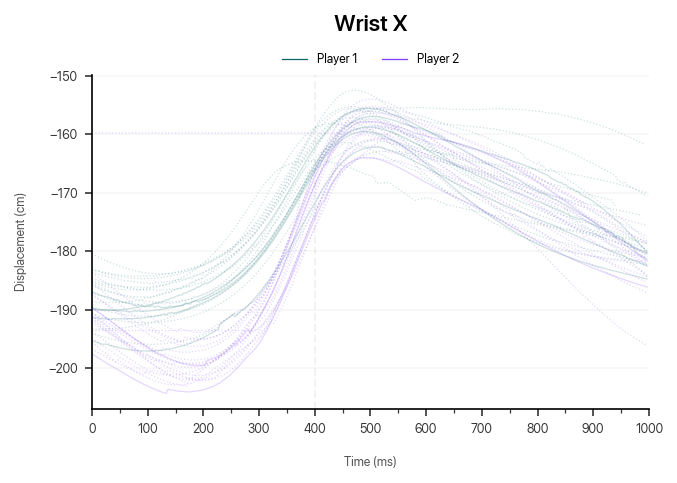

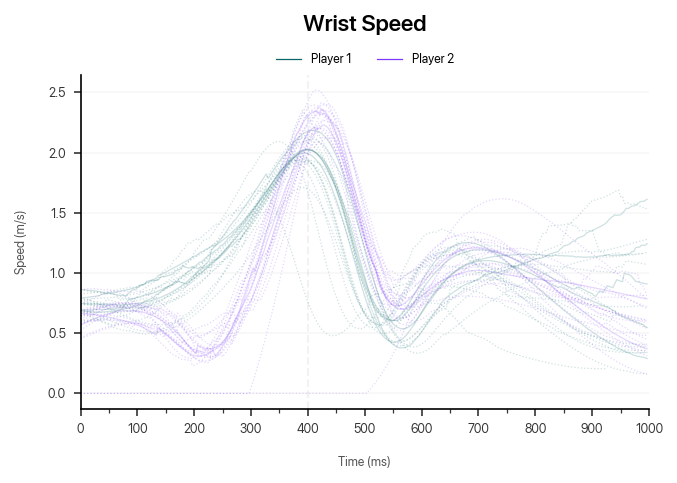

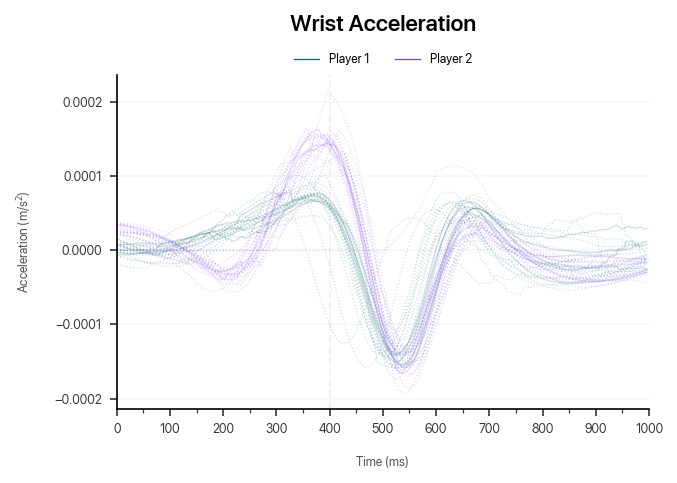

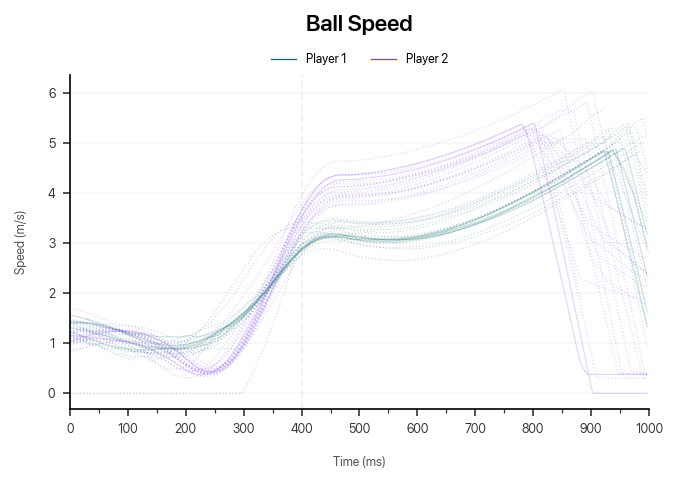

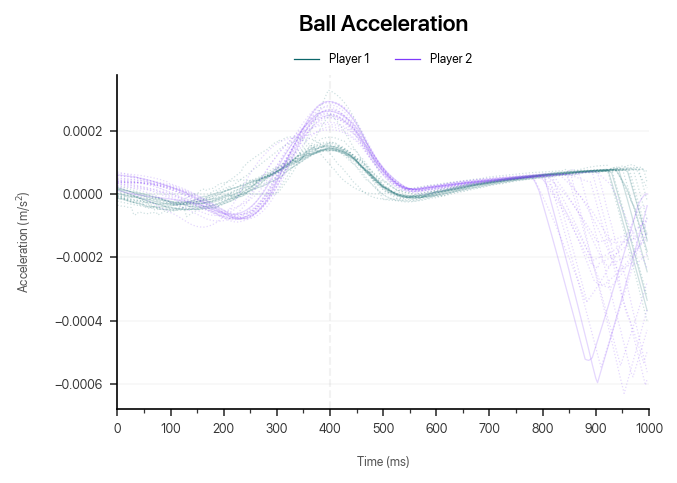

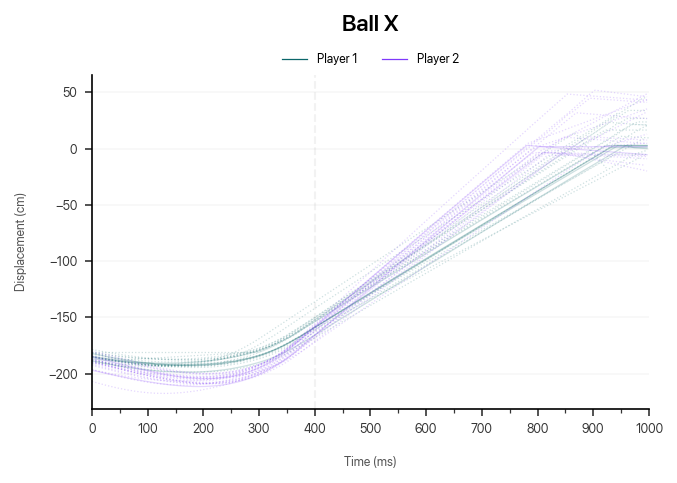

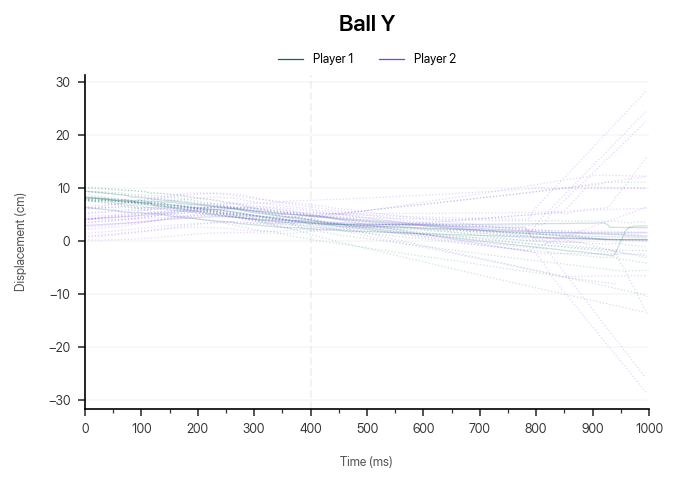

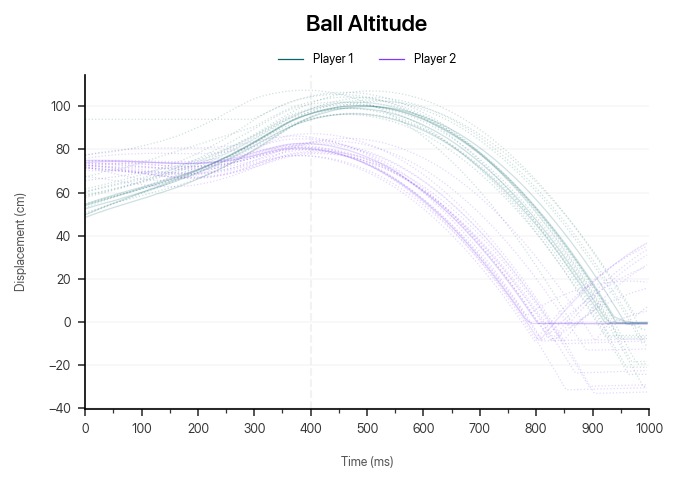

In [462]:
def plot_trajectory(marker, dimension):
    plt.figure()
    mark_dispatch()
    for index, (player, condition, recording) in data.iterrows():
        for trial, subset in recording.items():
            plt.plot(
                subset[marker]["Time"],
                subset[marker][dimension], 
                color = "C0" if player == 1 else "C2",
                linewidth = 0.6, 
                linestyle = "-" if subset.outcome else ":",
                alpha = 0.2
            )

    dimension = dimension if not dimension == "Z" else "Altitude"
    plt.title(f"{marker} {dimension}\n")
    plt.xlabel("Time (ms)")
    if dimension == "Speed":
        plt.ylabel(f"{dimension} (m/s)")
    elif dimension == "Acceleration":
        plt.ylabel(f"{dimension} (m/s$^2$)")
    else:
        plt.ylabel("Displacement (cm)")

    decorate_xaxis_ticks()
    plt.legend(handles = [lines.Line2D([0], [0], color=color, linewidth = 0.6) for color in ("C0", "C2")], labels = ["Player 1", "Player 2"], loc = "upper center", bbox_to_anchor = (0.5, 1.1), ncol = 2)
    plt.margins(x = 0, y = 0.05)
    plt.tight_layout()
    plt.savefig(SHOWCASE_PATH.joinpath(f"{marker}_{dimension}.png"), dpi = 300, bbox_inches = "tight")

plot_trajectory(marker = "Wrist", dimension = "X")
plot_trajectory(marker = "Wrist", dimension = "Speed")
plot_trajectory(marker = "Wrist", dimension = "Acceleration")
plot_trajectory(marker = "Ball", dimension = "Speed")
plot_trajectory(marker = "Ball", dimension = "Acceleration")
plot_trajectory(marker = "Ball", dimension = "X")
plot_trajectory(marker = "Ball", dimension = "Y")
plot_trajectory(marker = "Ball", dimension = "Z")

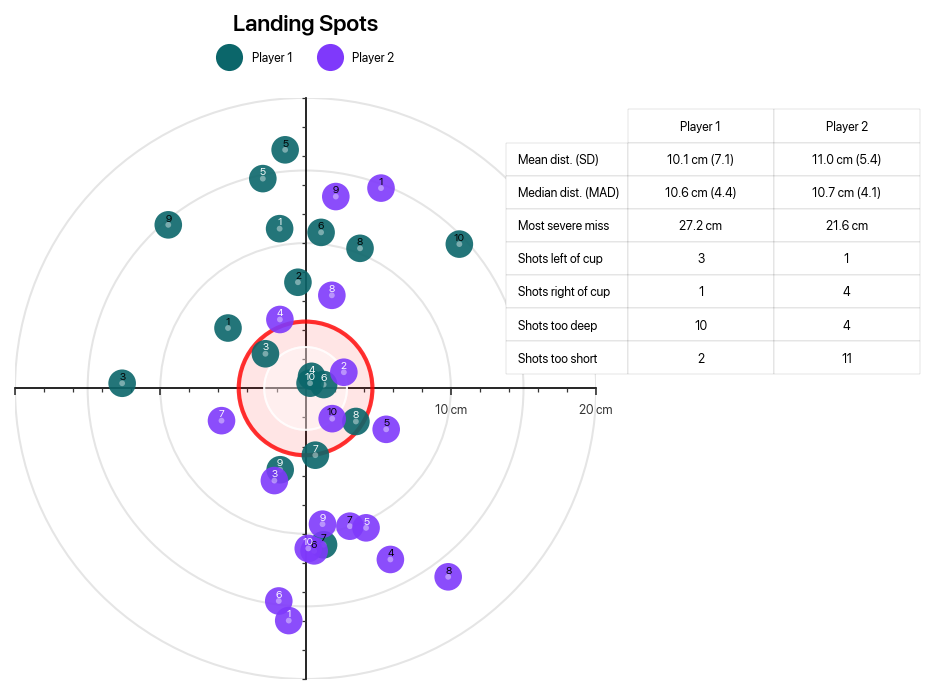

In [463]:
def plot_round_target():
    figure, axes = plt.subplots(figsize = (6.5, 4.5), ncols=2, width_ratios=[4.5, 2], gridspec_kw = dict(wspace = 0))
    disc_ax, summary_ax = axes

    disc_ax.spines["left"].set(zorder = -1)
    disc_ax.spines["bottom"].set(zorder = -1)
    disc_ax.spines["left"].set_position("center")
    disc_ax.spines["bottom"].set_position("center")
    disc_ax.add_patch(patches.Circle((0, 0), 4.6, color="red", alpha = 0.1))
    disc_ax.add_patch(patches.Circle((0, 0), 2.85, color="white", alpha = 0.4))
    disc_ax.add_patch(patches.Circle((0, 0), 2.85, color="white", alpha = 0.8, fill = False, linewidth = 1))
    disc_ax.add_patch(patches.Circle((0, 0), 4.6, color="red", alpha = 0.8, fill = False, linewidth = 2))
    for radius in (10, 15, 20):
        disc_ax.add_patch(patches.Circle((0, 0), radius, color="black", fill = False, alpha = 0.1))

    points = []
    for index, (player, condition, recording) in data.iterrows():
        for trial, subset in recording.items():
            ball_under_cup_plane = subset["Ball"][subset["Ball"]["Z"] <= CENTROID_OFFSET + 0.5].iloc[0] if subset["Ball"]["Z"].min() <= CENTROID_OFFSET + 0.5 else subset["Ball"].iloc[subset["Ball"]["Z"].idxmax()]

            touchdown_point = ball_under_cup_plane[["X", "Y"]] # point at which ball crosses transverse plane of cup
            points.append(dict(
                Player = player,
                Trial = trial,
                Condition = condition,
                Lateral = touchdown_point["Y"], # in the coordinate system of the recording, the Y-axis is lateral
                Longitude = touchdown_point["X"],
            ))

    zoom_range = 20
    landing_spots = pd.DataFrame(points)
    landing_spots["Distance"] = np.sqrt((landing_spots[["Lateral", "Longitude"]]**2).sum(axis = 1))

    for index, point in landing_spots[landing_spots["Distance"] <= zoom_range].iterrows():
        disc_ax.add_patch(plt.Circle(
            (point["Lateral"], point["Longitude"]),
            radius = BALL_RADIUS, 
            color = "C0" if point["Player"] == 1 else "C2",
            linewidth = 0,
            alpha = 0.9,
        ))
        disc_ax.add_patch(plt.Circle(
            (point["Lateral"], point["Longitude"]),
            radius = 0.2, 
            color = "white",
            linewidth = 0,
            alpha = 0.4
        ))
        disc_ax.annotate(
            point["Trial"],
            (point["Lateral"], point["Longitude"]),
            fontsize = 5,
            textcoords = "offset points",
            color = "white" if point["Condition"] == "Daylight" else "black",
            horizontalalignment = "center",
            xytext=(0, 2), 
        )

    disc_ax.set_title("Landing Spots\n\n")
    disc_ax.set_xlim((-zoom_range, zoom_range))
    disc_ax.set_ylim((-zoom_range, zoom_range))
    disc_ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    disc_ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    disc_ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))
    disc_ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
    disc_ax.set_yticks([])
    disc_ax.set_xticks(range(-zoom_range, zoom_range + 1, 10), [str(i) + " cm" if i > 0 else "" for i in range(-zoom_range, zoom_range + 1, 10)])
    disc_ax.grid(False)
    disc_ax.set_aspect("equal")

    measures = landing_spots.groupby("Player").agg(**{
        "Mean dist. (SD)": ("Distance", lambda vals: f"{vals.mean():.1f} cm ({vals.std():.1f})"),
        "Median dist. (MAD)": ("Distance", lambda vals: f"{vals.median():.1f} cm ({np.median(np.absolute(vals - np.median(vals))):.1f})"),
        "Most severe miss": ("Distance", lambda vals: f"{vals.max():.1f} cm"),
        "Shots left of cup": ("Lateral", lambda vals: f"{(vals < -(CUP_RADIUS + BALL_RADIUS)).sum()}"),
        "Shots right of cup": ("Lateral", lambda vals: f"{(vals > (CUP_RADIUS + BALL_RADIUS)).sum()}"),
        "Shots too deep": ("Longitude", lambda vals: f"{(vals > (CUP_RADIUS + BALL_RADIUS)).sum()}"),
        "Shots too short": ("Longitude", lambda vals: f"{(vals < -(CUP_RADIUS + BALL_RADIUS)).sum()}"),
    }).T

    disc_ax.legend(
        handles = [lines.Line2D([0], [0], marker = "o", color=color, markersize = 12, linewidth=0) for color in ("C0", "C2")], 
        labels = [f"Player {player_id}" for player_id in measures.columns], 
        loc = "upper center",
        bbox_to_anchor = (0.5, 1.1),
        ncol = 2,
    )

    table = summary_ax.table(
        measures.values,
        colLabels = [f"Player {player_id}" for player_id in measures.columns],
        rowLabels = measures.index,
        colLoc = "center",
        cellLoc = "center",
        loc = "upper right"
    )
    for key, cell in table.get_celld().items():
        cell.set_linewidth(0.05)
    summary_ax.axis("off")

    plt.tight_layout()
    plt.savefig(SHOWCASE_PATH.joinpath("landing_spot.png"), dpi = 300, bbox_inches = "tight")

plot_round_target()

In [464]:
def summary():
    result = []
    for index, (player, condition, recording) in data.iterrows():
        for trial, subset in recording.items():

            after_passing_cup = subset["Ball"]["Z"] <= 0

            result.append({
                "Player": player, 
                "Condition": condition, 
                "Trial": trial, 
                "Outcome": "Hit" if subset.outcome else "Miss",
                "Ball Max Speed (m/s)": subset["Ball"]["Speed"].max(), 
                "Ball Max Altitude (cm)": subset["Ball"]["Z"].max(),
                "Ball Altitude at Cup Projection (cm)": subset["Ball"][after_passing_cup].iloc[0]["Z"] if after_passing_cup.any() else np.nan,
                "Wrist Max Speed (m/s)": subset["Wrist"]["Speed"].max(),
                "Distance to Cup at Dispatch (cm)": -subset["Ball"].iloc[int(DISPATCH_MARGIN * SAMPLE_RATE)]["X"],
                "Deviation from Centerline at Dispatch (cm)": subset["Ball"].iloc[int(DISPATCH_MARGIN * SAMPLE_RATE)]["Y"],
                "Elbow Altitude at Dispatch (cm)": subset["Elbow"]["Z"].loc[subset["Ball"]["Speed"].idxmax()],
            })

    return pd.DataFrame(result).set_index(["Player", "Condition", "Trial"]).round(2)

summary()

Outcome  Ball Max Speed (m/s)  Ball Max Altitude (cm)  \
Player Condition Trial                                                         
1      Darkness  1        Miss                  5.08                  104.39   
                 2        Miss                  5.23                  100.92   
                 3        Miss                  5.02                  102.99   
                 4        Miss                  5.20                  106.58   
                 5        Miss                  5.29                  105.65   
                 6        Miss                  5.70                  107.56   
                 7        Miss                  4.86                  107.22   
                 8        Miss                  5.31                  102.03   
                 9        Miss                  5.12                  104.19   
                 10       Miss                  5.13                  102.09   
       Daylight  1        Miss                  5.32                   99.15   
                 2        Miss                  5.49                   96.83   
                 3         Hit                  4.86                  100.39   
                 4         Hit                  4.83                   96.55   
                 5        Miss                  5.41                   96.31   
                 6         Hit                  4.89                   99.97   
                 7        Miss                  4.77                  102.44   
                 8         Hit                  4.83                   99.17   
                 9        Miss                  4.84                  101.93   
                 10        Hit                  4.87                  100.31   
2      Darkness  1        Miss                  5.81                   83.26   
                 2        Miss                  5.14                   79.89   
                 3        Miss                  6.02                   87.33   
                 4        Miss                  5.00                   85.21   
                 5        Miss                  5.09                   83.99   
                 6        Miss                  5.11                   82.49   
                 7        Miss                  5.15                   81.01   
                 8        Miss                  5.28                   81.95   
                 9        Miss                  6.06                   81.39   
                 10        Hit                  5.39                   82.78   
       Daylight  1        Miss                  5.38                   86.25   
                 2         Hit                  5.38                   80.70   
                 3        Miss                  5.30                   84.98   
                 4        Miss                  5.38                   80.12   
                 5        Miss                  5.28                   77.19   
                 6        Miss                  5.23                   80.21   
                 7        Miss                  5.27                   79.26   
                 8        Miss                  5.65                   78.61   
                 9        Miss                  5.19                   77.18   
                 10       Miss                  5.19                   78.11   

                        Ball Altitude at Cup Projection (cm)  \
Player Condition Trial                                         
1      Darkness  1                                     -0.24   
                 2                                     -0.31   
                 3                                     -0.42   
                 4                                     -1.39   
                 5                                     -0.34   
                 6                                     -1.08   
                 7                                     -0.66   
                 8                                     -1.20   
                 9    

In [ ]:
# excluded_markers = ["Ball"]
# all_positional_data = pd.concat([data[1][marker][["X", "Y", "Z"]].add_prefix(marker + "_") for marker in session.available_markers if marker not in excluded_markers], axis=1).dropna(axis = 1)
# scaled_data = preprocessing.scale(all_positional_data.T)

# def principal_component_analysis():
#     n_components = 3
#     pca = decomposition.PCA(n_components)
#     pca.fit(scaled_data)
#     component_labels = ["PC" + str(i) for i in range(1, n_components + 1)]

#     plt.figure(figsize=(4.5, 1.5))
#     plt.title("Principal Component Analysis")
#     plt.barh(component_labels[::-1], pca.explained_variance_ratio_[::-1])
#     plt.xlim((0, 1))
#     plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
#     plt.xlabel("Relative importance (weight)")
#     plt.ylabel("Component")
#     plt.tight_layout()

#     plt.figure()
#     pca_data = pd.DataFrame(pca.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
#     plt.scatter(pca_data["PC1"], pca_data["PC2"], s = 5)
#     for marker, components in pca_data.iterrows():
#         plt.annotate(" " + marker, (components["PC1"], components["PC2"]), fontsize = 6)
#     plt.margins(x = 0.1)
#     plt.xlabel("PC1")
#     plt.ylabel("PC2")
#     plt.tight_layout()

# def independent_component_analysis():
#     n_components = 2
#     ica = decomposition.FastICA(n_components)
#     ica.fit(scaled_data)
#     component_labels = ["IC" + str(i) for i in range(1, n_components + 1)]

#     plt.figure()
#     plt.title("Independent Component Analysis")
#     ica_data = pd.DataFrame(ica.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
#     plt.scatter(ica_data["IC1"], ica_data["IC2"], s = 5)
#     for marker, components in ica_data.iterrows():
#         plt.annotate(" " + marker, (components["IC1"], components["IC2"]), fontsize = 6)
#     plt.margins(x = 0.1)
#     plt.xlabel("IC1")
#     plt.ylabel("IC2")
#     plt.tight_layout()

# principal_component_analysis()
# independent_component_analysis()